In [ ]:
# Baseline 1: ARMA model, NVDA spot price
# Baseline 2: ARMA model, log scale, NVDA spot price

ARMA model for NVDA spot price:
Scrape using Beautiful Soup, display using Pandas

In [4]:
# Imports
# To import, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import os
import lxml
import pandas as pd
from bs4 import BeautifulSoup
from scipy import stats, signal
from scipy.optimize import minimize
import yfinance as yf
import datetime as dt
from datetime import date, datetime, timedelta
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

# Magic function to enable matplotlib charting in jupyter notebooks
%matplotlib inline

In [4]:
# Tickers
nvda = yf.Ticker("NVDA") 
qqq = yf.Ticker("QQQ")

In [49]:
data = nvda.history(period="5y", interval="1wk")
qqq_data = qqq.history(period="5y", interval="1wk")

In [53]:
print(data.head())

                               Open      High  ...  Dividends  Stock Splits
Date                                           ...                         
2020-02-24 00:00:00-05:00  6.524150  6.857503  ...      0.004           0.0
2020-03-02 00:00:00-05:00  6.897723  7.096758  ...      0.000           0.0
2020-03-09 00:00:00-04:00  5.976035  6.503640  ...      0.000           0.0
2020-03-16 00:00:00-04:00  5.291243  5.737390  ...      0.000           0.0
2020-03-23 00:00:00-04:00  5.124343  6.554457  ...      0.000           0.0

[5 rows x 7 columns]


In [51]:
#export
csvx = data[['Open', 'High', 'Low', 'Close']].to_csv("nvda_weekly_spot.csv", float_format="%.3f")
csvnq = qqq_data[['Open', 'High', 'Low', 'Close']].to_csv("qqq_weekly_spot.csv", float_format="%.3f")

In [52]:
print(data.describe())

             Open        High  ...   Dividends  Stock Splits
count  262.000000  262.000000  ...  262.000000    262.000000
mean    42.125947   44.504179  ...    0.000374      0.053435
std     41.121486   43.313976  ...    0.001432      0.664514
min      5.124343    5.737390  ...    0.000000      0.000000
25%     14.171155   14.829985  ...    0.000000      0.000000
50%     22.236909   23.060505  ...    0.000000      0.000000
75%     48.096403   49.811496  ...    0.000000      0.000000
max    148.669750  153.130005  ...    0.010000     10.000000

[8 rows x 7 columns]


In [42]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-02-24 00:00:00-05:00 to 2025-02-24 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          262 non-null    float64
 1   High          262 non-null    float64
 2   Low           262 non-null    float64
 3   Close         262 non-null    float64
 4   Volume        262 non-null    int64  
 5   Dividends     262 non-null    float64
 6   Stock Splits  262 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 16.4 KB


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [43]:
dfm = pd.read_csv("nvda_weekly_spot.csv")
print(dfm.head())

                        Date   Open   High    Low  Close
0  2020-02-24 00:00:00-05:00  6.524  6.858  6.020  6.724
1  2020-03-02 00:00:00-05:00  6.898  7.097  6.427  6.627
2  2020-03-09 00:00:00-04:00  5.976  6.504  5.376  5.999
3  2020-03-16 00:00:00-04:00  5.291  5.737  4.501  5.125
4  2020-03-23 00:00:00-04:00  5.124  6.554  4.945  6.296


In [8]:
# This class will download daily data from yahoo finance
class DailyFinancialData:
    
    # Class constructor to store parameters, download and format data
    def __init__(self, ticker, startDate, endDate):
        
        # Member Data
        self.ticker = ticker
        self.startDate = startDate
        self.endDate = endDate

        # Download and format data
        self.download_data()
        self.prepare_data()

    # Download data from yahoo finance
    def download_data(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        self.raw_data = yf.download(self.ticker, self.startDate, self.endDate)

    # Compute returns and drop NaN values
    def prepare_data(self):
        
        # Grab columns of interest
        copy_columns = ['Close']
        self.df = self.raw_data[copy_columns].copy()
        
        # Compute returns and drop NaN values
        self.df["Returns"] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        self.df.dropna(inplace=True)
    
    def plot_data(self, cols=None):
        if cols is None:
            cols = ['Close']
        self.df[cols].plot(title=self.ticker)
    
    def show_data(self):
        print("\n*** HEAD ***")
        print(self.df.head())

        print("\n*** TAIL ***")
        print(self.df.tail())

In [9]:
# This class will download tick data from yahoo finance
class TickFinancialData:
    
    # Class constructor to store parameters, download and format data
    # Note that period will show the current price (delayed by around 15 mins)
    def __init__(self, ticker, period, interval, price_column):
        
        # Member Data
        self.ticker = ticker
        self.price_column = price_column
        
        # The period can be "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", or "ytd
        self.period = period 
        
        # The interval can be "1m", "2m", "5m", "10m", "30m", "1h", "1d", "1wk", "1mo" etc.
        self.interval = interval
        
        # Download and format data
        self.download_data()
        self.prepare_data()

    # Download data from yahoo finance
    def download_data(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        print(f"(15m Delayed Data)")
        
        instrument = yf.Ticker(self.ticker)
        self.raw_data = instrument.history(period=self.period, interval=self.interval)
        
        print(f"Last Time Index - {self.raw_data.index[-1]}")
        
    # Compute returns and drop NaN values
    def prepare_data(self):
        
        # Grab columns of interest
        self.data = self.raw_data[[self.price_column]].copy()
        
        # Compute returns and drop NaN values
        self.data["Returns"] = np.log(self.data[[self.price_column]] / self.data[[self.price_column]].shift(1))
        self.data.dropna(inplace=True)
        
    def plot_data(self, cols=None):
        if cols is None:
            cols = self.price_column
        self.data[cols].plot(title=self.ticker)
    
    def show_data(self):
        print("\n*** HEAD ***")
        print(self.data.head())

        print("\n*** TAIL ***")
        print(self.data.tail())

In [18]:
class FinancialData:
    '''
    This class handles retrieves financial data from Yahoo Finance.
    Works with both daily data and intraday/tick data, and was designed to 
    get beyond Yahoo's 60-day limit for tick data.
    '''
    
    def __init__(self, ticker, start_date=None, end_date=None, interval="1d", period=None):
        '''
        
        Class parameters:
        ticker (str): The stock ticker symbol
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        data_type (int): Type of data to retrieve - 0 for daily or 1 for intraday #data_type=0,
        interval (str): Data interval - '1d' for daily, or '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h' for intraday
        period (str): Alternative to start_date - e.g., '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
        '''
        
        # Member data
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        #self.data_type = data_type
        self.interval = interval
        self.period = period
        self.raw_data = None
        self.df = None
        
        # Download and prepare data
        self.download_data()
        self.prepare_data()
    
    def download_data(self):
        '''
        Downloads data from Yahoo Finance based on interval.
        '''
        print(f"Downloading {self.interval} interval data for {self.ticker}")
        interval_set = ["1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h"]
        if self.interval == "1d":
            # Uses yf history() method for daily data
            ticker_obj = yf.Ticker(self.ticker)
            if self.period:
                self.raw_data = ticker_obj.history(period=self.period)
            elif self.start_date:
                self.raw_data = ticker_obj.history(start=self.start_date, end=self.end_date)
            else:
                # If no start date or period, get default data (1 month)
                self.raw_data = ticker_obj.history(period="1mo")
                
        elif self.interval in interval_set:
            # Uses a custom chunking method for intraday data
            # Calculate total duration in days
            if self.start_date:
                start_date = datetime.strptime(self.start_date, '%Y-%m-%d')
                end_date = datetime.strptime(self.end_date, '%Y-%m-%d')
                duration_days = (end_date - start_date).days
            else:
                # Default: get last 59 days
                duration_days = 59
                end_date = datetime.strptime(self.end_date, '%Y-%m-%d')
            
            self.raw_data = self._get_extended_intraday_data(end_date, duration_days)
        
        else:
            raise ValueError("Incorrect interval")
    
    def _get_extended_intraday_data(self, end_date, duration_days):
        '''
        Retrieve intraday data beyond the 60-day limit using functional programming.
        
        Parameters:
        end_date (datetime): End date for data collection
        duration_days (int): Total number of days to retrieve
        
        Returns:
        pandas.DataFrame: Combined historical data
        '''
        chunk_size = 59  # Maximum days per request
        
        # Create function to generate a date chunk
        def create_date_chunk(offset):
            chunk_end = end_date - timedelta(days=offset)
            days_remaining = duration_days - offset
            chunk_size_adjusted = min(chunk_size, days_remaining)
            chunk_start = chunk_end - timedelta(days=chunk_size_adjusted)
            return (chunk_start, chunk_end)
        
        # Map: Create all date chunks
        date_chunks = list(map(create_date_chunk, range(0, duration_days, chunk_size)))
        
        # Function to download data for a chunk
        def download_chunk(date_range):
            start_date, end_date = date_range
            print(f"Fetching {self.interval} data from {start_date.date()} to {end_date.date()}")
            
            df = yf.download(
                self.ticker, 
                start=start_date.strftime('%Y-%m-%d'), 
                end=end_date.strftime('%Y-%m-%d'), 
                interval=self.interval
            )
            
            time.sleep(1)  # Avoid rate limiting
            return df
        
        # Map: Apply download function to each chunk
        chunk_data = list(map(download_chunk, date_chunks))
        
        # Filter: Remove empty dataframes
        valid_chunks = list(filter(lambda df: not df.empty, chunk_data))
        
        try:
            # Reduce: Combine all dataframes
            all_data = reduce(lambda df1, df2: pd.concat([df1, df2]), valid_chunks)
            
            # Remove any duplicate dates and sort
            return all_data[~all_data.index.duplicated(keep='first')].sort_index()
        except TypeError:  # If no valid chunks were found
            return pd.DataFrame()
    
    def prepare_data(self):
        '''
        Prepare data for analysis - compute returns and clean data.
        '''
        if self.raw_data is None or self.raw_data.empty:
            print("No data available to prepare.")
            self.df = pd.DataFrame()
            return
        
        # Grab columns of interest
        copy_columns = ['Open', 'High', 'Low', 'Close', 'Volume'] 
        available_columns = [col for col in copy_columns if col in self.raw_data.columns]
        
        if available_columns:
            self.df = self.raw_data[available_columns].copy()
            
            if 'Close' in self.df.columns:
                # Compute returns and drop NaN values
                self.df["Returns"] = np.log(self.df['Close'] / self.df['Close'].shift(1))
                self.df.dropna(inplace=True)
        else:
            # Handle case when expected columns are missing
            self.df = self.raw_data.copy()
    
    def plot_data(self, cols=None):
        '''
        Plot the specified columns of data.
        
        Parameters:
        cols (list): List of column names to plot. Defaults to ['Close'].
        '''
        if self.df is None or self.df.empty:
            print("No data available to plot.")
            return
        
        if cols is None:
            cols = ['Close']
        
        # Make sure all requested columns exist
        available_cols = [col for col in cols if col in self.df.columns]
        if not available_cols:
            print(f"None of the requested columns {cols} arse available. Available columns are: {self.df.columns.tolist()}")
            return
            
        self.df[available_cols].plot(title=self.ticker)
        plt.show()
    
    def show_data(self):
        """
        Display the head and tail of the data.
        """
        if self.df is None or self.df.empty:
            print("No data available to show.")
            return
            
        print("\n*** HEAD ***")
        print(self.df.head())
        print("\n*** TAIL ***")
        print(self.df.tail())
    
    def get_data(self):
        """
        Return the processed dataframe.
        """
        return self.df

[*********************100%***********************]  1 of 1 completed

Fetching 30m data from 2025-01-09 to 2025-03-09



*** HEAD ***
Price                            Open        High  ...    Volume   Returns
Ticker                           NVDA        NVDA  ...      NVDA          
Datetime                                           ...                    
2025-01-10 15:00:00+00:00  135.380005  136.169998  ...  22840421  0.005681
2025-01-10 15:30:00+00:00  136.158997  137.419998  ...  18951955 -0.003910
2025-01-10 16:00:00+00:00  135.610001  135.880005  ...  11283111  0.000000
2025-01-10 16:30:00+00:00  135.610001  136.130005  ...  10470696 -0.003990
2025-01-10 17:00:00+00:00  135.089996  136.199997  ...   8811796  0.008037

[5 rows x 6 columns]

*** TAIL ***
Price                            Open        High  ...    Volume   Returns
Ticker                           NVDA        NVDA  ...      NVDA          
Datetime                                           ...                    
2025-03-07 18:30:00+00:00  110.529999  111.443604  ...  15864702  0.006864
2025-03-07 19:00:00+00:00  111.269997  112.514999 

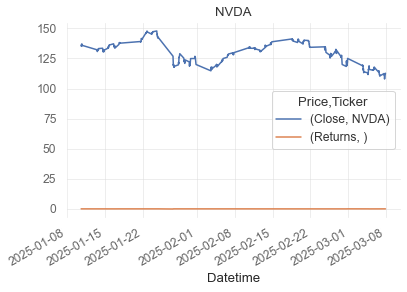

In [20]:
#New FinancialData class example:
nvda_data = FinancialData("NVDA", interval="30m", period="6mo")
nvda_data.show_data()
nvda_data.plot_data(['Close', 'Returns'])

[*********************100%***********************]  1 of 1 completed


*** HEAD ***
Price           Close   Returns
Ticker           NVDA          
Date                           
2023-02-14  22.954304  0.052873
2023-02-15  22.747452 -0.009052
2023-02-16  21.986008 -0.034047
2023-02-17  21.372454 -0.028303
2023-02-21  20.639986 -0.034873

*** TAIL ***
Price            Close   Returns
Ticker            NVDA          
Date                            
2025-03-03  114.059998 -0.090949
2025-03-04  115.989998  0.016779
2025-03-05  117.300003  0.011231
2025-03-06  110.570000 -0.059086
2025-03-07  112.690002  0.018992


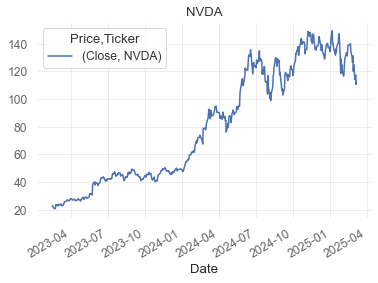

In [10]:
# Example 1: NVDA
# 1. Define ticker
ticker = "NVDA"

# 2. Define backtest period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load data
fd = DailyFinancialData(ticker, startDate, endDate)

# 4. Plot data
fd.show_data()
fd.plot_data()

(15m Delayed Data)
Last Time Index - 2025-03-07 15:45:00-05:00

*** HEAD ***
                                Close   Returns
Datetime                                       
2024-12-09 09:45:00-05:00  139.669998  0.004568
2024-12-09 10:00:00-05:00  138.945007 -0.005204
2024-12-09 10:15:00-05:00  138.660004 -0.002053
2024-12-09 10:30:00-05:00  138.350006 -0.002238
2024-12-09 10:45:00-05:00  137.830002 -0.003766

*** TAIL ***
                                Close   Returns
Datetime                                       
2025-03-07 14:45:00-05:00  111.900002  0.002909
2025-03-07 15:00:00-05:00  112.448898  0.004893
2025-03-07 15:15:00-05:00  112.605003  0.001387
2025-03-07 15:30:00-05:00  111.934998 -0.005968
2025-03-07 15:45:00-05:00  112.730003  0.007077


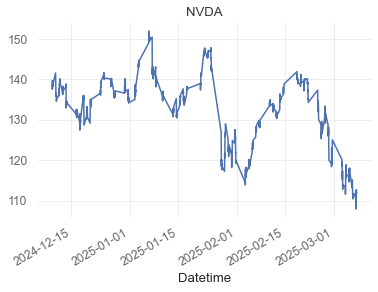

In [30]:
# Tick data: NVDA
# Set Ticker, Data Period and Time Interval
# Note: All tick data is delayed by 15 minutes.
ticker = "NVDA"
period = "60d"    # The period can be between 1 and 60 days
interval = "15m"  # Working intervals: 5m, 15m, 30m, 1h, 90m
price_column = "Close"
# Download and Format Financial Data
fd = TickFinancialData(ticker, period, interval, price_column)

# Show Data
fd.show_data()
fd.plot_data()

[*********************100%***********************]  1 of 1 completed

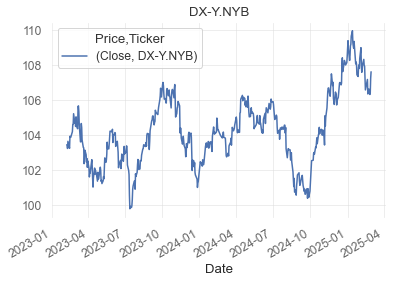

In [8]:
# Example 2: DXY
# 1. Define ticker
ticker = "DX-Y.NYB"

# 2. Define backtest period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load data
fd = DailyFinancialData(ticker, startDate, endDate)

# 4. Plot data
fd.plot_data()